In [ ]:
!pip install torch torchvision torchsummary --quiet
# installing lib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.2 MB/s eta 0:00:00


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
import cv2
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#unzip dataset
!unzip -q "/content/drive/MyDrive/Dataset/TB Chest X-ray database.zip" -d "/content/TB_dataset"

replace /content/TB_dataset/TB_Chest_Radiography_Database/Normal.metadata.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/TB_dataset/TB_Chest_Radiography_Database/Normal.metadata.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/TB_dataset/TB_Chest_Radiography_Database/Normal/Normal-1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
y


In [ ]:
# Path dataset
base_path = "/content/TB_dataset/TB_Chest_Radiography_Database"

# Check path yang digunakan
print(f"Dataset path: {base_path}")

#verif dataset
print("isi dataset")
!ls "/content/TB_dataset"
print("nClass folders:")
!ls "/content/TB_dataset/TB_Chest_Radiography_Database"


Dataset path: /content/TB_dataset/TB_Chest_Radiography_Database
isi dataset
TB_Chest_Radiography_Database
nClass folders:
Normal		      README.md.txt  Tuberculosis.metadata.xlsx
Normal.metadata.xlsx  Tuberculosis


Membuat seed tetap agar code dapat direproduksi alias keacakan awal bisa ditetapkan sehingga akan mendapatkan hasil yang sama

In [ ]:
# Memastikan hasil yang konsisten
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

Code ini untuk menunjukkan komposisi dataset dan jumlah kelas, dan gambar masing-masing kelas untuk sebagai preview dan gambaran data yang akan digunakan

Statistik Dataset:
Total gambar: 4200
Jumlah gambar Normal: 3500 (83.33%)
Jumlah gambar TB: 700 (16.67%)
Rasio class imbalance: 5.00:1 (Normal:TB)


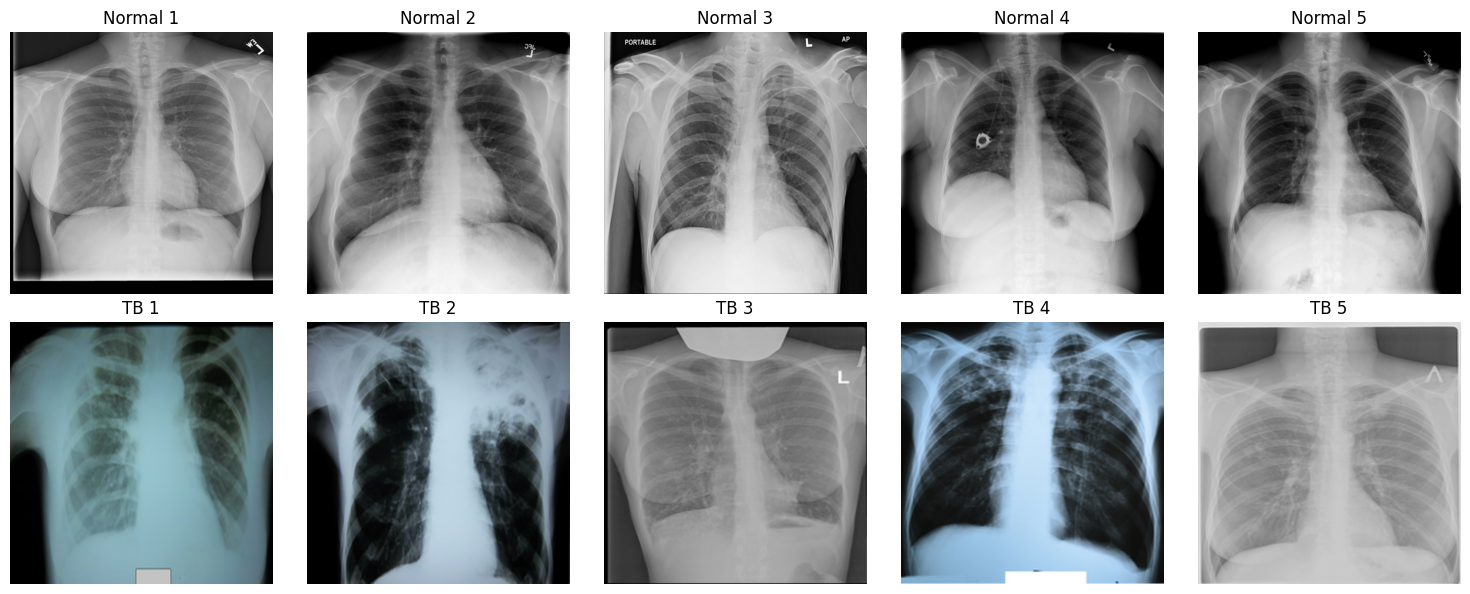

In [ ]:
# Menampilkan statistik dataset dan sampel gambar
normal_dir = os.path.join(base_path, "Normal")
tb_dir = os.path.join(base_path, "Tuberculosis")

# Menghitung jumlah gambar per kelas
normal_imgs = [f for f in os.listdir(normal_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
tb_imgs = [f for f in os.listdir(tb_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

num_normal = len(normal_imgs)
num_tb = len(tb_imgs)
total_images = num_normal + num_tb

print(f"Statistik Dataset:")
print(f"Total gambar: {total_images}")
print(f"Jumlah gambar Normal: {num_normal} ({num_normal/total_images*100:.2f}%)")
print(f"Jumlah gambar TB: {num_tb} ({num_tb/total_images*100:.2f}%)")
print(f"Rasio class imbalance: {num_normal/num_tb:.2f}:1 (Normal:TB)")

# Menampilkan beberapa sampel gambar dari setiap kelas
plt.figure(figsize=(15, 6))

# Sampel gambar Normal
for i in range(5):
    if i < len(normal_imgs):
        plt.subplot(2, 5, i+1)
        img_path = os.path.join(normal_dir, normal_imgs[i])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konversi BGR ke RGB
        plt.imshow(img)
        plt.title(f"Normal {i+1}")
        plt.axis('off')

# Sampel gambar TB
for i in range(5):
    if i < len(tb_imgs):
        plt.subplot(2, 5, i+6)
        img_path = os.path.join(tb_dir, tb_imgs[i])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konversi BGR ke RGB
        plt.imshow(img)
        plt.title(f"TB {i+1}")
        plt.axis('off')

plt.tight_layout()
plt.show()



1.   **Kelas RandomGamma** disini digunakan untuk koreksi gamma secara acak pada gambar yang diimput, koreksi tersebut merupakan teknik untuk menyesuaikan kecerahan gambar dengan mengangkat nilai pikesel ke pangkat tertentu (gamma) dengan menerapkannya secara acak dapat disimulasikan variasi kondisi pencahayaan, sehingga berguna saat berurusan dengan gambar X-ray
2.   **Kelas AdaptiveAugmentation** digunakan untuk menerapkan augmentasi yang berbeda berdasarkan kelas yang ditentukan alias kelas minoritas (TB) untuk sebagai penyeimbang dataset dan meningkatkan kemampuan model dalam mempelajari fitur kelas minoritas

kedua cara ini digunakan penting dalam mengatasi variasi citra medis dan dapat meningkatkan performa model



In [ ]:
# Definisi kelas augmentasi khusus untuk citra medis
class RandomGamma(torch.nn.Module):
    """Menerapkan koreksi gamma secara acak pada citra input.
    Berguna untuk mensimulasikan variasi pencahayaan pada citra X-ray."""
    def __init__(self, gamma_range=(0.8, 1.2)):
        super().__init__()
        self.gamma_range = gamma_range

    def forward(self, img):
        if torch.rand(1).item() > 0.5:  # 50% kemungkinan untuk diterapkan
            gamma = random.uniform(self.gamma_range[0], self.gamma_range[1])
            return torch.pow(img, gamma)
        return img

class AdaptiveAugmentation:
    """Menerapkan augmentasi berbeda berdasarkan label kelas.
    Ini memungkinkan kita untuk melakukan augmentasi lebih agresif pada kelas minoritas (TB)."""
    def __init__(self, base_transform, enhanced_transform):
        self.base_transform = base_transform      # Untuk kelas mayoritas (Normal)
        self.enhanced_transform = enhanced_transform  # Untuk kelas minoritas (TB)

    def __call__(self, image, label):
        if label == 1:  # Kelas TB (minoritas)
            return self.enhanced_transform(image), label
        else:  # Kelas Normal (mayoritas)
            return self.base_transform(image), label

Code dibawah digunakan untuk mendefinisikan augmentasi gambar dan melihat augmentasi gambar, hal ini dilakukan untuk meningkatkan kinerja model dengan memberikan variasi data yang lebih luas untuk dipelajari model selama pelatihan.

Contoh augmentasi pada gambar Normal:


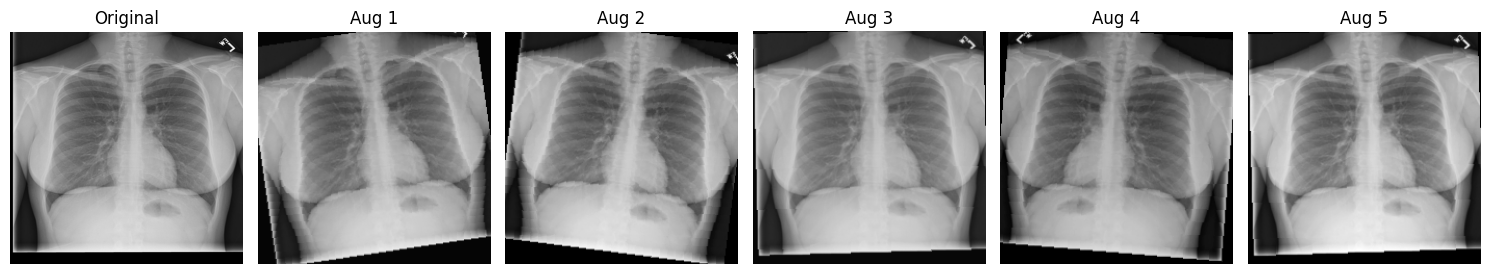

Contoh augmentasi pada gambar TB (augmentasi lebih agresif):


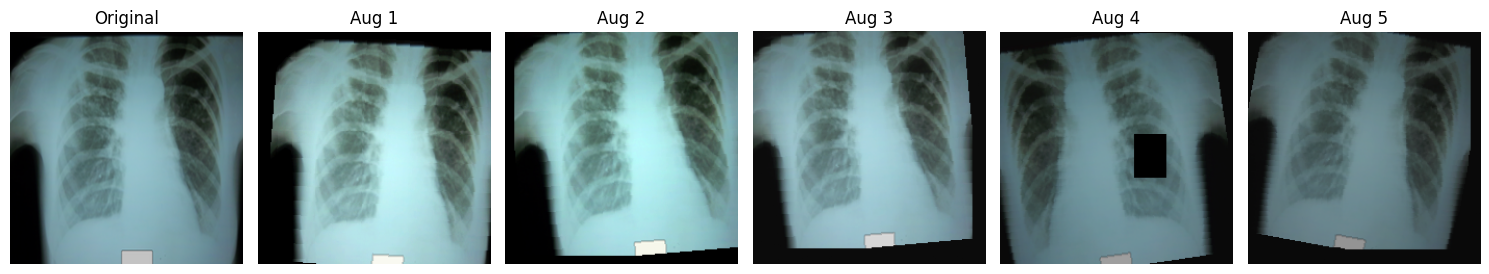

In [ ]:
# Visualisasi hasil augmentasi pada gambar
def visualize_augmentations(image_path, transform, num_samples=5):
    """Menampilkan hasil augmentasi pada gambar."""
    # Baca gambar asli
    original_img = Image.open(image_path).convert('RGB')

    plt.figure(figsize=(15, 4))

    # Tampilkan gambar asli
    plt.subplot(1, num_samples+1, 1)
    plt.imshow(original_img)
    plt.title("Original")
    plt.axis('off')

    # Tampilkan hasil augmentasi
    for i in range(num_samples):
        # Terapkan transformasi
        augmented_img = transform(original_img)

        # Konversi tensor ke numpy untuk visualisasi
        if isinstance(augmented_img, torch.Tensor):
            # Denormalisasi jika perlu
            if augmented_img.min() < 0 or augmented_img.max() > 1:
                mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
                std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
                augmented_img = augmented_img * std + mean

            augmented_img = augmented_img.permute(1, 2, 0).numpy()  # CHW -> HWC
            augmented_img = np.clip(augmented_img, 0, 1)

        plt.subplot(1, num_samples+1, i+2)
        plt.imshow(augmented_img)
        plt.title(f"Aug {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Definisi transformasi gambar
def get_transforms():
    # Transformasi dasar untuk kelas normal (mayoritas)
    base_transform = transforms.Compose([
        transforms.Resize((224, 224)),              # Ubah ukuran gambar menjadi 224x224
        transforms.RandomHorizontalFlip(p=0.5),     # Flip horizontal secara acak (50% kemungkinan)
        transforms.RandomRotation(10),              # Rotasi acak hingga 10 derajat
        transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Variasi kecerahan dan kontras
        transforms.ToTensor(),                      # Konversi ke tensor
        RandomGamma(gamma_range=(0.9, 1.1)),        # Transformasi gamma khusus medis
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalisasi standar ImageNet
                             std=[0.229, 0.224, 0.225])
    ])

    # Transformasi yang ditingkatkan untuk kelas TB (minoritas)
    enhanced_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),              # Rotasi yang sedikit lebih besar
        transforms.RandomAffine(                    # Transformasi afin (translasi dan penskalaan)
            degrees=0,
            translate=(0.05, 0.05),                 # Translasi hingga 5% dari ukuran
            scale=(0.95, 1.05)                      # Penskalaan dari 95% hingga 105%
        ),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),  # Variasi warna lebih besar
        transforms.RandomAutocontrast(p=0.3),       # Penyesuaian kontras otomatis
        transforms.ToTensor(),
        RandomGamma(gamma_range=(0.8, 1.2)),        # Range gamma yang lebih lebar
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(                   # Hapus area acak pada gambar
            p=0.2,                                  # 20% kemungkinan diterapkan
            scale=(0.02, 0.05)                       # Ukuran area yang dihapus
        )
    ])

    # Transformasi untuk data test (tanpa augmentasi)
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    return base_transform, enhanced_transform, test_transform

# Dapatkan transformasi
base_transform, enhanced_transform, test_transform = get_transforms()

# Visualisasi augmentasi pada sampel gambar
if len(normal_imgs) > 0:
    normal_img_path = os.path.join(normal_dir, normal_imgs[0])
    print("Contoh augmentasi pada gambar Normal:")
    # Buat versi transformasi tanpa normalisasi untuk visualisasi
    viz_base_transform = transforms.Compose([t for t in base_transform.transforms if not isinstance(t, transforms.Normalize)])
    visualize_augmentations(normal_img_path, viz_base_transform)

if len(tb_imgs) > 0:
    tb_img_path = os.path.join(tb_dir, tb_imgs[0])
    print("Contoh augmentasi pada gambar TB (augmentasi lebih agresif):")
    # Buat versi transformasi tanpa normalisasi untuk visualisasi
    viz_enhanced_transform = transforms.Compose([t for t in enhanced_transform.transforms if not isinstance(t, transforms.Normalize)])
    visualize_augmentations(tb_img_path, viz_enhanced_transform)

Code dibawah digunakan untuk mempersiapkan data untuk digunakan dalam model, dengan diawali memuat gambar selanjutnya di splitting awal menjadi 80%/20% antara train/val dengan test lalu di split lagi antara train dengan val dari 80% tersebut menjadi 64%/16%

mengapa splitting data mengalami pembagian dua kali
1.   meningkatkan kemampuan generalisasi model pada data yang baru yaitu (test data)
2.   memberikan estimasi kinerja yang realistis maksudnya model akan beperforma lebih lanjut karena dihadapkan data yang belum pernah diliat

Testing set yang tidak termasuk atau dilihat di pembagian kedua akan berperan sebagai data baru yang belum pernah dilihat model sebelumnya sehingga memmberikan gambaran yang lebih realistis ketika bertemu data yang baru



In [ ]:
# Preprocessing dataset
# Menentukan lokasi dataset
normal_dir = os.path.join(base_path, "Normal")
tb_dir = os.path.join(base_path, "Tuberculosis")

# Mengumpulkan semua path gambar
normal_paths = [os.path.join(normal_dir, f) for f in os.listdir(normal_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
tb_paths = [os.path.join(tb_dir, f) for f in os.listdir(tb_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Menggabungkan path dan membuat label
all_paths = normal_paths + tb_paths
all_labels = [0]*len(normal_paths) + [1]*len(tb_paths)

# Split pertama: memisahkan data test (80% train+val, 20% test)
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    all_paths,
    all_labels,
    test_size=0.2,            # 20% data untuk testing
    stratify=all_labels,      # Memastikan distribusi kelas seimbang
    random_state=42           # Untuk reprodusibilitas hasil
)

# Split kedua: membagi data train+val menjadi train dan validasi
# (80% dari 80% = 64% train, 20% dari 80% = 16% val)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths,
    train_val_labels,
    test_size=0.2,            # 20% dari train+val untuk validasi
    stratify=train_val_labels, # Memastikan distribusi kelas seimbang
    random_state=42           # Untuk reprodusibilitas hasil
)

# Menampilkan informasi jumlah data
print(f"Jumlah sampel training: {len(train_paths)}")
print(f"Jumlah sampel validasi: {len(val_paths)}")
print(f"Jumlah sampel testing: {len(test_paths)}")

# Menampilkan distribusi kelas pada setiap dataset
print(f"Distribusi kelas - Training: Normal={train_labels.count(0)}, TB={train_labels.count(1)}")
print(f"Distribusi kelas - Validasi: Normal={val_labels.count(0)}, TB={val_labels.count(1)}")
print(f"Distribusi kelas - Testing: Normal={test_labels.count(0)}, TB={test_labels.count(1)}")

# Menghitung dan menampilkan rasio kelas untuk setiap dataset
train_ratio = train_labels.count(0) / train_labels.count(1) if train_labels.count(1) > 0 else float('inf')
val_ratio = val_labels.count(0) / val_labels.count(1) if val_labels.count(1) > 0 else float('inf')
test_ratio = test_labels.count(0) / test_labels.count(1) if test_labels.count(1) > 0 else float('inf')

print(f"Rasio Normal:TB - Training: {train_ratio:.2f}:1")
print(f"Rasio Normal:TB - Validasi: {val_ratio:.2f}:1")
print(f"Rasio Normal:TB - Testing: {test_ratio:.2f}:1")

Jumlah sampel training: 2688
Jumlah sampel validasi: 672
Jumlah sampel testing: 840
Distribusi kelas - Training: Normal=2240, TB=448
Distribusi kelas - Validasi: Normal=560, TB=112
Distribusi kelas - Testing: Normal=700, TB=140
Rasio Normal:TB - Training: 5.00:1
Rasio Normal:TB - Validasi: 5.00:1
Rasio Normal:TB - Testing: 5.00:1


Code dibawah dimaksudkan untuk memudahkan memasukan data ke (DataLoader) yang digunakan untuk menyediakan batch data secara efisien ke model selama pelatihan

In [ ]:
class TBDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, adaptive_aug=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.adaptive_aug = adaptive_aug

    def __len__(self): # Mengembalikan total sampel dalam dataset
        return len(self.image_paths)

    def __getitem__(self, idx): # Untuk mengakses data tertentu (gambar dan label) menggunakan indeksnya
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.adaptive_aug:
            image, label = self.adaptive_aug(image, label)
        elif self.transform:
            image = self.transform(image)

        return image, label

Code dibahwa adalah mempersiapkan data untuk model, yang berfokus dalam penanganan ketidakseimbangan kelas, dengan menggunakan weighted sampler selama pelatihan dan menerapkan lebih banyak augmentasi ke kelas minor.

In [ ]:
def create_weighted_sampler(labels):
    class_counts = [labels.count(0), labels.count(1)]
    weights = [1/class_counts[label] for label in labels] # bobot tb (minoritas) akan memiliki bobot lebih tinggi untuk menyeimbangkan data
    return WeightedRandomSampler(weights, len(weights), replacement=True)

# Membuat dataset untuk setiap split data
train_dataset = TBDataset(
    image_paths=train_paths,
    labels=train_labels,
    adaptive_aug=AdaptiveAugmentation(base_transform, enhanced_transform)  # Augmentasi yang adaptif untuk training
)

val_dataset = TBDataset(
    image_paths=val_paths,
    labels=val_labels,
    transform=test_transform  # Tidak perlu augmentasi untuk validasi
)

test_dataset = TBDataset(
    image_paths=test_paths,
    labels=test_labels,
    transform=test_transform  # Tidak perlu augmentasi untuk testing
)

# Membuat weighted sampler untuk mengatasi ketidakseimbangan kelas di data training
train_sampler = create_weighted_sampler(train_labels)

# Membuat DataLoaders
batch_size = 128
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=train_sampler,      # Menggunakan weighted sampler untuk training
    num_workers=2               # Jumlah worker untuk memuat data
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,              # Tidak perlu mengacak data validasi
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,              # Tidak perlu mengacak data testing
    num_workers=2
)

# Visualisasi distribusi kelas sebelum dan sesudah penyeimbangan
print("\nAnalisis penyeimbangan kelas:")

# Distribusi asli di dataset training
orig_normal = train_dataset.labels.count(0)
orig_tb = train_dataset.labels.count(1)
print(f"Distribusi asli dataset training: Normal={orig_normal}, TB={orig_tb}")
print(f"Rasio: {orig_normal / orig_tb:.2f}:1 (Normal:TB)")


Analisis penyeimbangan kelas:
Distribusi asli dataset training: Normal=2240, TB=448
Rasio: 5.00:1 (Normal:TB)


Code dibawah ini dimaksudkan untuk mensimulasikan pengambilan sample dan memvisualisasikan distribusi dataset pada setiap batch


Analisis penyeimbangan kelas:
Distribusi asli dataset: Normal=2240, TB=448
Rasio: 5.00:1 (Normal:TB)
Distribusi setelah penyeimbangan: Normal=980, TB=1020
Rasio setelah penyeimbangan: 0.96:1 (Normal:TB)


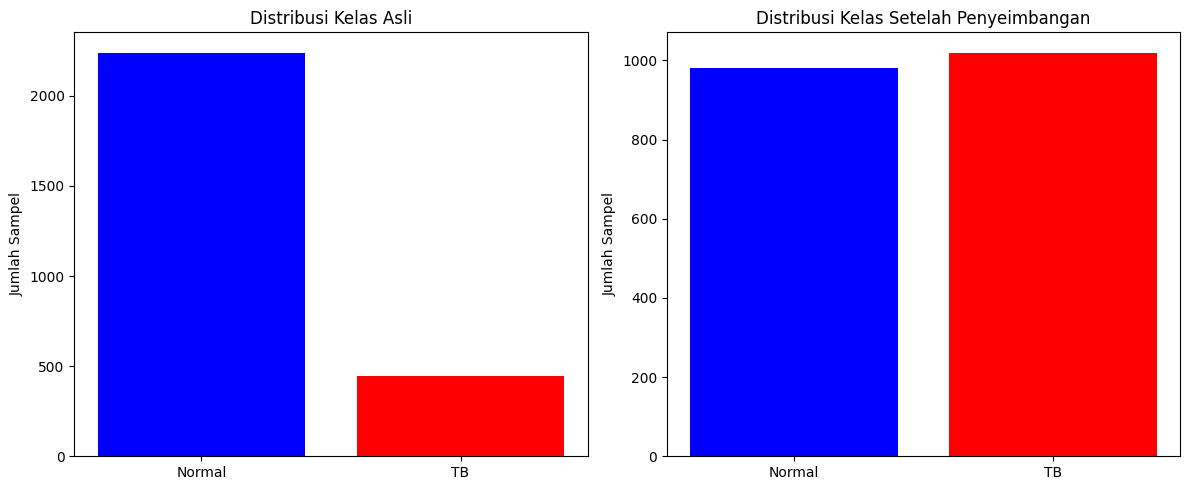


Distribusi kelas dalam 5 batch pertama setelah penyeimbangan:
Batch 1: Normal=56, TB=72, Rasio=0.78:1
Batch 2: Normal=62, TB=66, Rasio=0.94:1
Batch 3: Normal=66, TB=62, Rasio=1.06:1
Batch 4: Normal=73, TB=55, Rasio=1.33:1
Batch 5: Normal=61, TB=67, Rasio=0.91:1


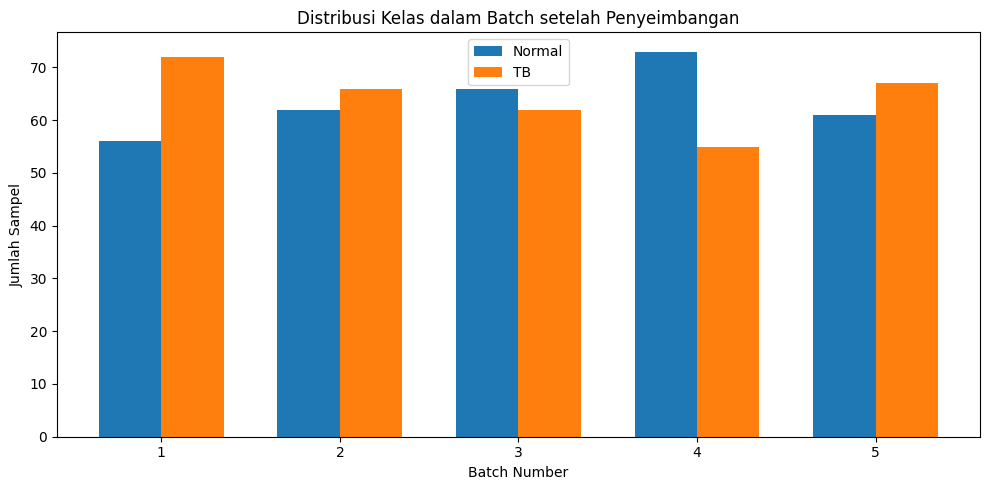

In [ ]:
# Visualisasi distribusi kelas sebelum dan sesudah penyeimbangan
print("\nAnalisis penyeimbangan kelas:")
# Distribusi asli
orig_normal = train_dataset.labels.count(0)
orig_tb = train_dataset.labels.count(1)
print(f"Distribusi asli dataset: Normal={orig_normal}, TB={orig_tb}")
print(f"Rasio: {orig_normal / orig_tb:.2f}:1 (Normal:TB)")

# Simulasi sampling dengan WeightedRandomSampler
sampled_labels = []
num_samples = 2000  # Sampel sebanyak ini untuk analisis

# Buat iterator dari sampler
sampler_iter = iter(train_sampler)
for _ in range(num_samples):
    try:
        idx = next(sampler_iter)
        _, label = train_dataset[idx]
        sampled_labels.append(label)
    except StopIteration:
        break

# Hitung distribusi setelah penyeimbangan
sampled_normal = sampled_labels.count(0)
sampled_tb = sampled_labels.count(1)
print(f"Distribusi setelah penyeimbangan: Normal={sampled_normal}, TB={sampled_tb}")
print(f"Rasio setelah penyeimbangan: {sampled_normal / sampled_tb:.2f}:1 (Normal:TB)")

# Visualisasi perbandingan distribusi kelas
plt.figure(figsize=(12, 5))

# Plot distribusi asli
plt.subplot(1, 2, 1)
plt.bar(['Normal', 'TB'], [orig_normal, orig_tb], color=['blue', 'red'])
plt.title('Distribusi Kelas Asli')
plt.ylabel('Jumlah Sampel')

# Plot distribusi setelah penyeimbangan
plt.subplot(1, 2, 2)
plt.bar(['Normal', 'TB'], [sampled_normal, sampled_tb], color=['blue', 'red'])
plt.title('Distribusi Kelas Setelah Penyeimbangan')
plt.ylabel('Jumlah Sampel')

plt.tight_layout()
plt.show()

# Cek distribusi kelas dalam beberapa batch dari data loader
print("\nDistribusi kelas dalam 5 batch pertama setelah penyeimbangan:")
batch_count = 0
class_dist = []

for images, labels in train_loader:
    if batch_count >= 5:
        break
    normal_count = torch.sum(labels == 0).item()
    tb_count = torch.sum(labels == 1).item()
    print(f"Batch {batch_count+1}: Normal={normal_count}, TB={tb_count}, Rasio={normal_count/tb_count if tb_count > 0 else float('inf'):.2f}:1")
    class_dist.append((normal_count, tb_count))
    batch_count += 1

# Visualisasi distribusi kelas dalam batch
plt.figure(figsize=(10, 5))
batch_nums = list(range(1, len(class_dist) + 1))
normal_counts = [dist[0] for dist in class_dist]
tb_counts = [dist[1] for dist in class_dist]

width = 0.35
plt.bar([i - width/2 for i in batch_nums], normal_counts, width, label='Normal')
plt.bar([i + width/2 for i in batch_nums], tb_counts, width, label='TB')

plt.xlabel('Batch Number')
plt.ylabel('Jumlah Sampel')
plt.title('Distribusi Kelas dalam Batch setelah Penyeimbangan')
plt.xticks(batch_nums)
plt.legend()

plt.tight_layout()
plt.show()

Code ini adalah Model ConvNext yang digunakan adalah model Convnext_tiny (pre-trained) untuk mengadaptasi tugas klasifikasi gambar X-ray yang memiliki 2 kelas yaitu normal dan TB.

In [ ]:
# Definisi model ConvNeXt
class ConvNextModel(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvNextModel, self).__init__()
        # Gunakan ConvNeXt pre-trained sebagai backbone
        self.convnext = convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)
        # Ganti layer fully connected terakhir
        in_features = self.convnext.classifier[2].in_features
        self.convnext.classifier[2] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.convnext(x)

In [ ]:
from torchsummary import summary

# Inisialisasi model ConvNeXt
model_adam = ConvNextModel(num_classes=2).to(device) # Assuming model_adam is the model you want to summarize

# Print model summary
print("\n" + "="*50)
print("Model Summary (ConvNextModel)")
print("="*50)
# device could be 'cuda' or 'cpu' depending on availability
summary(model_adam, input_size=(3, 224, 224))


Model Summary (ConvNextModel)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
       LayerNorm2d-2           [-1, 96, 56, 56]             192
            Conv2d-3           [-1, 96, 56, 56]           4,800
           Permute-4           [-1, 56, 56, 96]               0
         LayerNorm-5           [-1, 56, 56, 96]             192
            Linear-6          [-1, 56, 56, 384]          37,248
              GELU-7          [-1, 56, 56, 384]               0
            Linear-8           [-1, 56, 56, 96]          36,960
           Permute-9           [-1, 96, 56, 56]               0
  StochasticDepth-10           [-1, 96, 56, 56]               0
          CNBlock-11           [-1, 96, 56, 56]               0
           Conv2d-12           [-1, 96, 56, 56]           4,800
          Permute-13           [-1, 56, 56, 96]               0
        

Code dibawah adalah fungsi untuk training model dalam pengklasifikasian gambar x-ray

In [ ]:
# Fungsi Training
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Membuat progress bar
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader),
                        desc="Training", leave=False)

    for batch_idx, (images, labels) in progress_bar:
        images, labels = images.to(device), labels.to(device)

        # Reset gradien parameter
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass dan optimisasi
        loss.backward()
        optimizer.step()

        # Hitung statistik
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': running_loss/(batch_idx+1),
            'acc': f"{100 * correct / total:.2f}%",
            'batch': f"{batch_idx+1}/{len(train_loader)}"
        })

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

Code dibawah adalah fungsi untuk evaluasi kinerja model dalam pengklasifikasian gambar x-ray, evaluasi ini dilakukan pada dataset test, hal ini digunakan untuk evaluasi hasil akhir karena dataset uji tidak pernah terlihat di loop training karena akan menggunakan dataset validasi sebagai evaluasi model saja

In [ ]:
# Fungsi Evaluasi
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    # Untuk akurasi per kelas
    class_correct = [0, 0]  # Untuk kelas Normal dan TB
    class_total = [0, 0]

    all_preds = []
    all_labels = []

    # Membuat progress bar
    progress_bar = tqdm(enumerate(test_loader), total=len(test_loader),
                       desc="Evaluating", leave=False)

    with torch.no_grad():
        for batch_idx, (images, labels) in progress_bar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Hitung akurasi per kelas
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += (predicted[i] == label).item()
                class_total[label] += 1

            # Update progress bar
            progress_bar.set_postfix({
                'loss': running_loss/(batch_idx+1),
                'acc': f"{100 * correct / total:.2f}%",
                'batch': f"{batch_idx+1}/{len(test_loader)}"
            })

    test_loss = running_loss / len(test_loader)
    test_acc = 100 * correct / total

    # Hitung akurasi per kelas
    normal_acc = 100 * class_correct[0] / class_total[0] if class_total[0] > 0 else 0
    tb_acc = 100 * class_correct[1] / class_total[1] if class_total[1] > 0 else 0

    return test_loss, test_acc, normal_acc, tb_acc, all_preds, all_labels

Code dibawah adalah untuk memberikan informasi kinerja model dalam mengklasifikasikan data

In [ ]:
# Fungsi untuk menghitung metrik evaluasi
def compute_metrics(all_preds, all_labels):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

    accuracy = accuracy_score(all_labels, all_preds) # persentase prediksi yang benar dari total prediksi.
    precision = precision_score(all_labels, all_preds, zero_division=0) #  prediksi positif yang benar dari total prediksi positif.
    recall = recall_score(all_labels, all_preds, zero_division=0) #  proporsi prediksi positif yang benar dari total sampel positif sebenarnya.
    f1 = f1_score(all_labels, all_preds, zero_division=0) # rata-rata harmonik antara presisi dan recall.
    cm = confusion_matrix(all_labels, all_preds) #  jumlah prediksi yang benar dan salah untuk setiap kelas

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }

Menginisialisasi model dan device yang digunakan (lebih baik gunakan cuda heheh)

In [ ]:
# Inisialisasi model dan device
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Menggunakan device: {device}")

# Inisialisasi model ConvNeXt
model_adam = ConvNextModel(num_classes=2).to(device)
model_adamw = ConvNextModel(num_classes=2).to(device)

Menggunakan device: cuda


Mengatur masing-masing optimizer

In [ ]:
# Definisikan optimizer
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer Adam
optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=0.00001)

# Optimizer AdamW
optimizer_adamw = torch.optim.AdamW(model_adamw.parameters())

Training loop untuk model optimizer Adam

In [ ]:
# Training loop untuk model dengan optimizer Adam
num_epochs = 8 # jumlah epochs

# Riwayat training untuk model Adam
history_adam = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],      # Metrik validasi
    'val_acc': [],       # Metrik validasi
    'val_normal_acc': [], # Akurasi kelas Normal pada validasi
    'val_tb_acc': [],    # Akurasi kelas TB pada validasi
    'test_loss': [],
    'test_acc': [],
    'normal_acc': [],    # Akurasi kelas Normal pada test
    'tb_acc': []         # Akurasi kelas TB pada test
}

print("\n" + "="*50)
print("Training ConvNeXt dengan optimizer Adam")
print("="*50)

# Early stopping variables
best_val_acc = 0
patience = 3
patience_counter = 0

for epoch in range(num_epochs):
    # Training
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(model_adam, train_loader, criterion, optimizer_adam, device)

    # Validasi
    print("Melakukan validasi...")
    val_loss, val_acc, val_normal_acc, val_tb_acc, val_preds, val_labels = evaluate(
        model_adam, val_loader, criterion, device)

    # Evaluasi pada set testing (hanya di epoch terakhir atau ketika early stopping)
    do_test_eval = (epoch == num_epochs - 1) or (patience_counter >= patience)

    if do_test_eval:
        print("Mengevaluasi pada data testing...")
        test_loss, test_acc, normal_acc, tb_acc, all_preds, all_labels = evaluate(
            model_adam, test_loader, criterion, device)
    else:
        test_loss, test_acc, normal_acc, tb_acc = None, None, None, None
        all_preds, all_labels = None, None

    # Menyimpan riwayat metrik
    history_adam['train_loss'].append(train_loss)
    history_adam['train_acc'].append(train_acc)
    history_adam['val_loss'].append(val_loss)
    history_adam['val_acc'].append(val_acc)
    history_adam['val_normal_acc'].append(val_normal_acc)
    history_adam['val_tb_acc'].append(val_tb_acc)

    if do_test_eval:
        history_adam['test_loss'].append(test_loss)
        history_adam['test_acc'].append(test_acc)
        history_adam['normal_acc'].append(normal_acc)
        history_adam['tb_acc'].append(tb_acc)

    # Menampilkan statistik
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Val Normal Acc: {val_normal_acc:.2f}%, Val TB Acc: {val_tb_acc:.2f}%")

    if do_test_eval:
        print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
        print(f"Test Normal Acc: {normal_acc:.2f}%, Test TB Acc: {tb_acc:.2f}%")

    print("-" * 50)

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        print(f"✓ Akurasi validasi meningkat menjadi {best_val_acc:.2f}%")
        # Simpan model terbaik
        torch.save(model_adam.state_dict(), 'convnext_adam_best_model.pth')
    else:
        patience_counter += 1
        print(f"✗ Tidak ada peningkatan akurasi validasi. Patience: {patience_counter}/{patience}")

    # Jika early stopping terpenuhi
    if patience_counter >= patience:
        print(f"Early stopping pada epoch {epoch+1}.")

        # Evaluasi model terbaik pada data test jika belum dilakukan
        if not do_test_eval:
            # Muat model terbaik
            model_adam.load_state_dict(torch.load('convnext_adam_best_model.pth'))
            print("Mengevaluasi model terbaik pada data testing...")
            test_loss, test_acc, normal_acc, tb_acc, all_preds, all_labels = evaluate(
                model_adam, test_loader, criterion, device)

            # Simpan hasil evaluasi
            history_adam['test_loss'].append(test_loss)
            history_adam['test_acc'].append(test_acc)
            history_adam['normal_acc'].append(normal_acc)
            history_adam['tb_acc'].append(tb_acc)

            print(f"Model terbaik - Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
            print(f"Model terbaik - Normal Acc: {normal_acc:.2f}%, TB Acc: {tb_acc:.2f}%")

        break

# Jika tidak terjadi early stopping, evaluasi pada set testing di epoch terakhir
if patience_counter < patience and epoch == num_epochs - 1:
    print("Mengevaluasi pada data testing...")
    test_loss, test_acc, normal_acc, tb_acc, all_preds, all_labels = evaluate(
        model_adam, test_loader, criterion, device)

    # Tambahkan ke riwayat
    if test_loss not in history_adam['test_loss']:
        history_adam['test_loss'].append(test_loss)
        history_adam['test_acc'].append(test_acc)
        history_adam['normal_acc'].append(normal_acc)
        history_adam['tb_acc'].append(tb_acc)

    print(f"Hasil akhir - Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    print(f"Hasil akhir - Normal Acc: {normal_acc:.2f}%, TB Acc: {tb_acc:.2f}%")


Training ConvNeXt dengan optimizer Adam

Epoch 1/8


Melakukan validasi...


Epoch 1/8
Train Loss: 0.4291, Train Acc: 86.16%
Val Loss: 0.2243, Val Acc: 96.58%
Val Normal Acc: 99.46%, Val TB Acc: 82.14%
--------------------------------------------------
✓ Akurasi validasi meningkat menjadi 96.58%

Epoch 2/8


Melakukan validasi...


Epoch 2/8
Train Loss: 0.1879, Train Acc: 96.39%
Val Loss: 0.1029, Val Acc: 98.51%
Val Normal Acc: 99.64%, Val TB Acc: 92.86%
--------------------------------------------------
✓ Akurasi validasi meningkat menjadi 98.51%

Epoch 3/8


Melakukan validasi...


Epoch 3/8
Train Loss: 0.0983, Train Acc: 98.25%
Val Loss: 0.0595, Val Acc: 99.11%
Val Normal Acc: 99.64%, Val TB Acc: 96.43%
--------------------------------------------------
✓ Akurasi validasi meningkat menjadi 99.11%

Epoch 4/8


Melakukan validasi...


Epoch 4/8
Train Loss: 0.0584, Train Acc: 98.70%
Val Loss: 0.0349, Val Acc: 99.26%
Val Normal Acc: 99.82%, Val TB Acc: 96.43%
--------------------------------------------------
✓ Akurasi validasi meningkat menjadi 99.26%

Epoch 5/8


Melakukan validasi...


Epoch 5/8
Train Loss: 0.0402, Train Acc: 99.03%
Val Loss: 0.0234, Val Acc: 99.55%
Val Normal Acc: 99.82%, Val TB Acc: 98.21%
--------------------------------------------------
✓ Akurasi validasi meningkat menjadi 99.55%

Epoch 6/8


Melakukan validasi...


Epoch 6/8
Train Loss: 0.0285, Train Acc: 99.55%
Val Loss: 0.0167, Val Acc: 99.55%
Val Normal Acc: 99.64%, Val TB Acc: 99.11%
--------------------------------------------------
✗ Tidak ada peningkatan akurasi validasi. Patience: 1/3

Epoch 7/8


Melakukan validasi...


Epoch 7/8
Train Loss: 0.0195, Train Acc: 99.59%
Val Loss: 0.0156, Val Acc: 99.70%
Val Normal Acc: 99.64%, Val TB Acc: 100.00%
--------------------------------------------------
✓ Akurasi validasi meningkat menjadi 99.70%

Epoch 8/8


Melakukan validasi...


Mengevaluasi pada data testing...


Epoch 8/8
Train Loss: 0.0136, Train Acc: 99.74%
Val Loss: 0.0173, Val Acc: 99.70%
Val Normal Acc: 99.64%, Val TB Acc: 100.00%
Test Loss: 0.0267, Test Acc: 99.40%
Test Normal Acc: 99.71%, Test TB Acc: 97.86%
--------------------------------------------------
✗ Tidak ada peningkatan akurasi validasi. Patience: 1/3
Mengevaluasi pada data testing...


Hasil akhir - Test Loss: 0.0267, Test Acc: 99.40%
Hasil akhir - Normal Acc: 99.71%, TB Acc: 97.86%


In [ ]:
# Training loop untuk model dengan optimizer Adamw
num_epochs = 5

# Riwayat training untuk model Adamw
history_adamw = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],      # Metrik validasi
    'val_acc': [],       # Metrik validasi
    'val_normal_acc': [], # Akurasi kelas Normal pada validasi
    'val_tb_acc': [],    # Akurasi kelas TB pada validasi
    'test_loss': [],
    'test_acc': [],
    'normal_acc': [],    # Akurasi kelas Normal pada test
    'tb_acc': []         # Akurasi kelas TB pada test
}

print("\n" + "="*50)
print("Training ConvNeXt dengan optimizer Adamw")
print("="*50)

# Early stopping variables
best_val_acc = 0
patience = 3
patience_counter = 0

for epoch in range(num_epochs):
    # Training
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(model_adamw, train_loader, criterion, optimizer_adamw, device)

    # Validasi
    print("Melakukan validasi...")
    val_loss, val_acc, val_normal_acc, val_tb_acc, val_preds, val_labels = evaluate(
        model_adamw, val_loader, criterion, device)

    # Evaluasi pada set testing (hanya di epoch terakhir atau ketika early stopping)
    do_test_eval = (epoch == num_epochs - 1) or (patience_counter >= patience)

    if do_test_eval:
        print("Mengevaluasi pada data testing...")
        test_loss, test_acc, normal_acc, tb_acc, all_preds, all_labels = evaluate(
            model_adamw, test_loader, criterion, device)
    else:
        test_loss, test_acc, normal_acc, tb_acc = None, None, None, None
        all_preds, all_labels = None, None

    # Menyimpan riwayat metrik
    history_adamw['train_loss'].append(train_loss)
    history_adamw['train_acc'].append(train_acc)
    history_adamw['val_loss'].append(val_loss)
    history_adamw['val_acc'].append(val_acc)
    history_adamw['val_normal_acc'].append(val_normal_acc)
    history_adamw['val_tb_acc'].append(val_tb_acc)

    if do_test_eval:
        history_adamw['test_loss'].append(test_loss)
        history_adamw['test_acc'].append(test_acc)
        history_adamw['normal_acc'].append(normal_acc)
        history_adamw['tb_acc'].append(tb_acc)

    # Menampilkan statistik
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Val Normal Acc: {val_normal_acc:.2f}%, Val TB Acc: {val_tb_acc:.2f}%")

    if do_test_eval:
        print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
        print(f"Test Normal Acc: {normal_acc:.2f}%, Test TB Acc: {tb_acc:.2f}%")

    print("-" * 50)

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        print(f"✓ Akurasi validasi meningkat menjadi {best_val_acc:.2f}%")
        # Simpan model terbaik
        torch.save(model_adamw.state_dict(), 'convnext_adamw_best_model.pth')
    else:
        patience_counter += 1
        print(f"✗ Tidak ada peningkatan akurasi validasi. Patience: {patience_counter}/{patience}")

    # Jika early stopping terpenuhi
    if patience_counter >= patience:
        print(f"Early stopping pada epoch {epoch+1}.")

        # Evaluasi model terbaik pada data test jika belum dilakukan
        if not do_test_eval:
            # Muat model terbaik
            model_adamw.load_state_dict(torch.load('convnext_adamw_best_model.pth'))
            print("Mengevaluasi model terbaik pada data testing...")
            test_loss, test_acc, normal_acc, tb_acc, all_preds, all_labels = evaluate(
                model_adamw, test_loader, criterion, device)

            # Simpan hasil evaluasi
            history_adamw['test_loss'].append(test_loss)
            history_adamw['test_acc'].append(test_acc)
            history_adamw['normal_acc'].append(normal_acc)
            history_adamw['tb_acc'].append(tb_acc)

            print(f"Model terbaik - Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
            print(f"Model terbaik - Normal Acc: {normal_acc:.2f}%, TB Acc: {tb_acc:.2f}%")

        break

# Jika tidak terjadi early stopping, evaluasi pada set testing di epoch terakhir
if patience_counter < patience and epoch == num_epochs - 1:
    print("Mengevaluasi pada data testing...")
    test_loss, test_acc, normal_acc, tb_acc, all_preds, all_labels = evaluate(
        model_adamw, test_loader, criterion, device)

    # Tambahkan ke riwayat
    if test_loss not in history_adamw['test_loss']:
        history_adamw['test_loss'].append(test_loss)
        history_adamw['test_acc'].append(test_acc)
        history_adamw['normal_acc'].append(normal_acc)
        history_adamw['tb_acc'].append(tb_acc)

    print(f"Hasil akhir - Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    print(f"Hasil akhir - Normal Acc: {normal_acc:.2f}%, TB Acc: {tb_acc:.2f}%")


Training ConvNeXt dengan optimizer Adamw

Epoch 1/5


Melakukan validasi...


Epoch 1/5
Train Loss: 0.2272, Train Acc: 90.89%
Val Loss: 0.0437, Val Acc: 98.36%
Val Normal Acc: 98.93%, Val TB Acc: 95.54%
--------------------------------------------------
✓ Akurasi validasi meningkat menjadi 98.36%

Epoch 2/5


Melakukan validasi...


Epoch 2/5
Train Loss: 0.0977, Train Acc: 96.28%
Val Loss: 0.0644, Val Acc: 98.51%
Val Normal Acc: 98.39%, Val TB Acc: 99.11%
--------------------------------------------------
✓ Akurasi validasi meningkat menjadi 98.51%

Epoch 3/5


Melakukan validasi...


Epoch 3/5
Train Loss: 0.0423, Train Acc: 98.59%
Val Loss: 0.0810, Val Acc: 96.88%
Val Normal Acc: 96.61%, Val TB Acc: 98.21%
--------------------------------------------------
✗ Tidak ada peningkatan akurasi validasi. Patience: 1/3

Epoch 4/5


Melakukan validasi...


Epoch 4/5
Train Loss: 0.0251, Train Acc: 99.14%
Val Loss: 0.0247, Val Acc: 98.96%
Val Normal Acc: 99.11%, Val TB Acc: 98.21%
--------------------------------------------------
✓ Akurasi validasi meningkat menjadi 98.96%

Epoch 5/5


Melakukan validasi...


Mengevaluasi pada data testing...


Epoch 5/5
Train Loss: 0.0319, Train Acc: 98.85%
Val Loss: 0.0100, Val Acc: 99.55%
Val Normal Acc: 99.82%, Val TB Acc: 98.21%
Test Loss: 0.0123, Test Acc: 99.52%
Test Normal Acc: 99.71%, Test TB Acc: 98.57%
--------------------------------------------------
✓ Akurasi validasi meningkat menjadi 99.55%
Mengevaluasi pada data testing...


Hasil akhir - Test Loss: 0.0123, Test Acc: 99.52%
Hasil akhir - Normal Acc: 99.71%, TB Acc: 98.57%


In [ ]:
def visualize_predictions_balanced(model, data_loader, title, num_samples_per_class=5):
    """
    Visualizes predictions with a balanced number of samples per class.
    """
    model.eval()

    # memasukan semua sample
    normal_images = []
    normal_labels = []
    tb_images = []
    tb_labels = []

    for images, labels in data_loader:
        for i in range(len(labels)):
            if labels[i] == 0 and len(normal_images) < num_samples_per_class:
                normal_images.append(images[i])
                normal_labels.append(labels[i])
            elif labels[i] == 1 and len(tb_images) < num_samples_per_class:
                tb_images.append(images[i])
                tb_labels.append(labels[i])

        if len(normal_images) == num_samples_per_class and len(tb_images) == num_samples_per_class:
            break

    # kombinasikan semua samples
    all_images = normal_images + tb_images
    all_labels = normal_labels + tb_labels

    # Convert to tensors and move to device
    all_images = torch.stack(all_images).to(device)
    all_labels = torch.stack(all_labels).to(device)

    with torch.no_grad():
        outputs = model(all_images)
        _, preds = torch.max(outputs, 1)

    # Denormalize images
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    denorm_images = all_images * std + mean
    denorm_images = torch.clamp(denorm_images, 0, 1)

    # Plot images with predictions
    plt.figure(figsize=(15, 6))  # Increased figure height
    plt.suptitle(title, y=1.05)  # Adjusted title position

    for i in range(len(all_images)):
        plt.subplot(2, num_samples_per_class, i + 1)  # 2 rows for classes
        img = denorm_images[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)

        true_label = "TB" if all_labels[i] else "Normal"
        pred_label = "TB" if preds[i] else "Normal"
        color = "green" if all_labels[i] == preds[i] else "red"

        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Visualisasi Sample Prediksi (Seimbang):


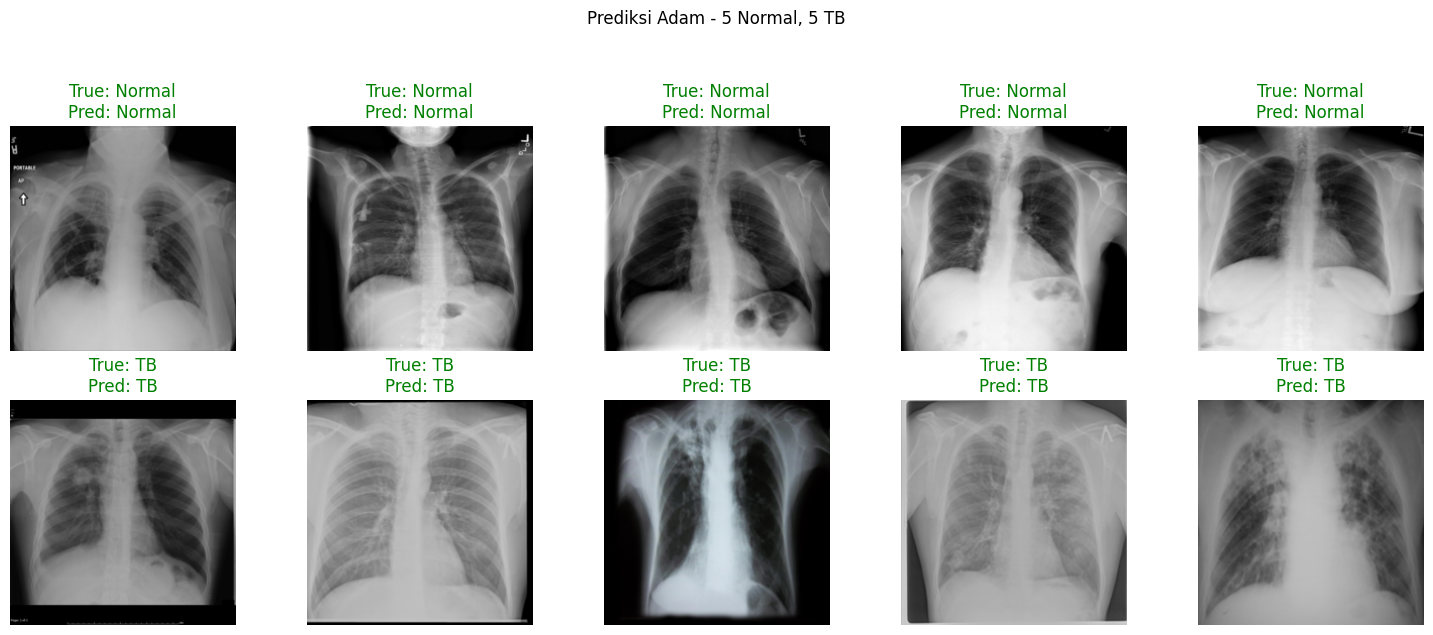

In [ ]:
# Visualisasi sample prediksi (seimbang)
print("\nVisualisasi Sample Prediksi (Seimbang):")

visualize_predictions_balanced(model_adam, test_loader, "Prediksi Adam - 5 Normal, 5 TB")
# visualize_predictions_balanced(model_adamw, test_loader, "Prediksi AdamW - 5 Normal, 5 TB")

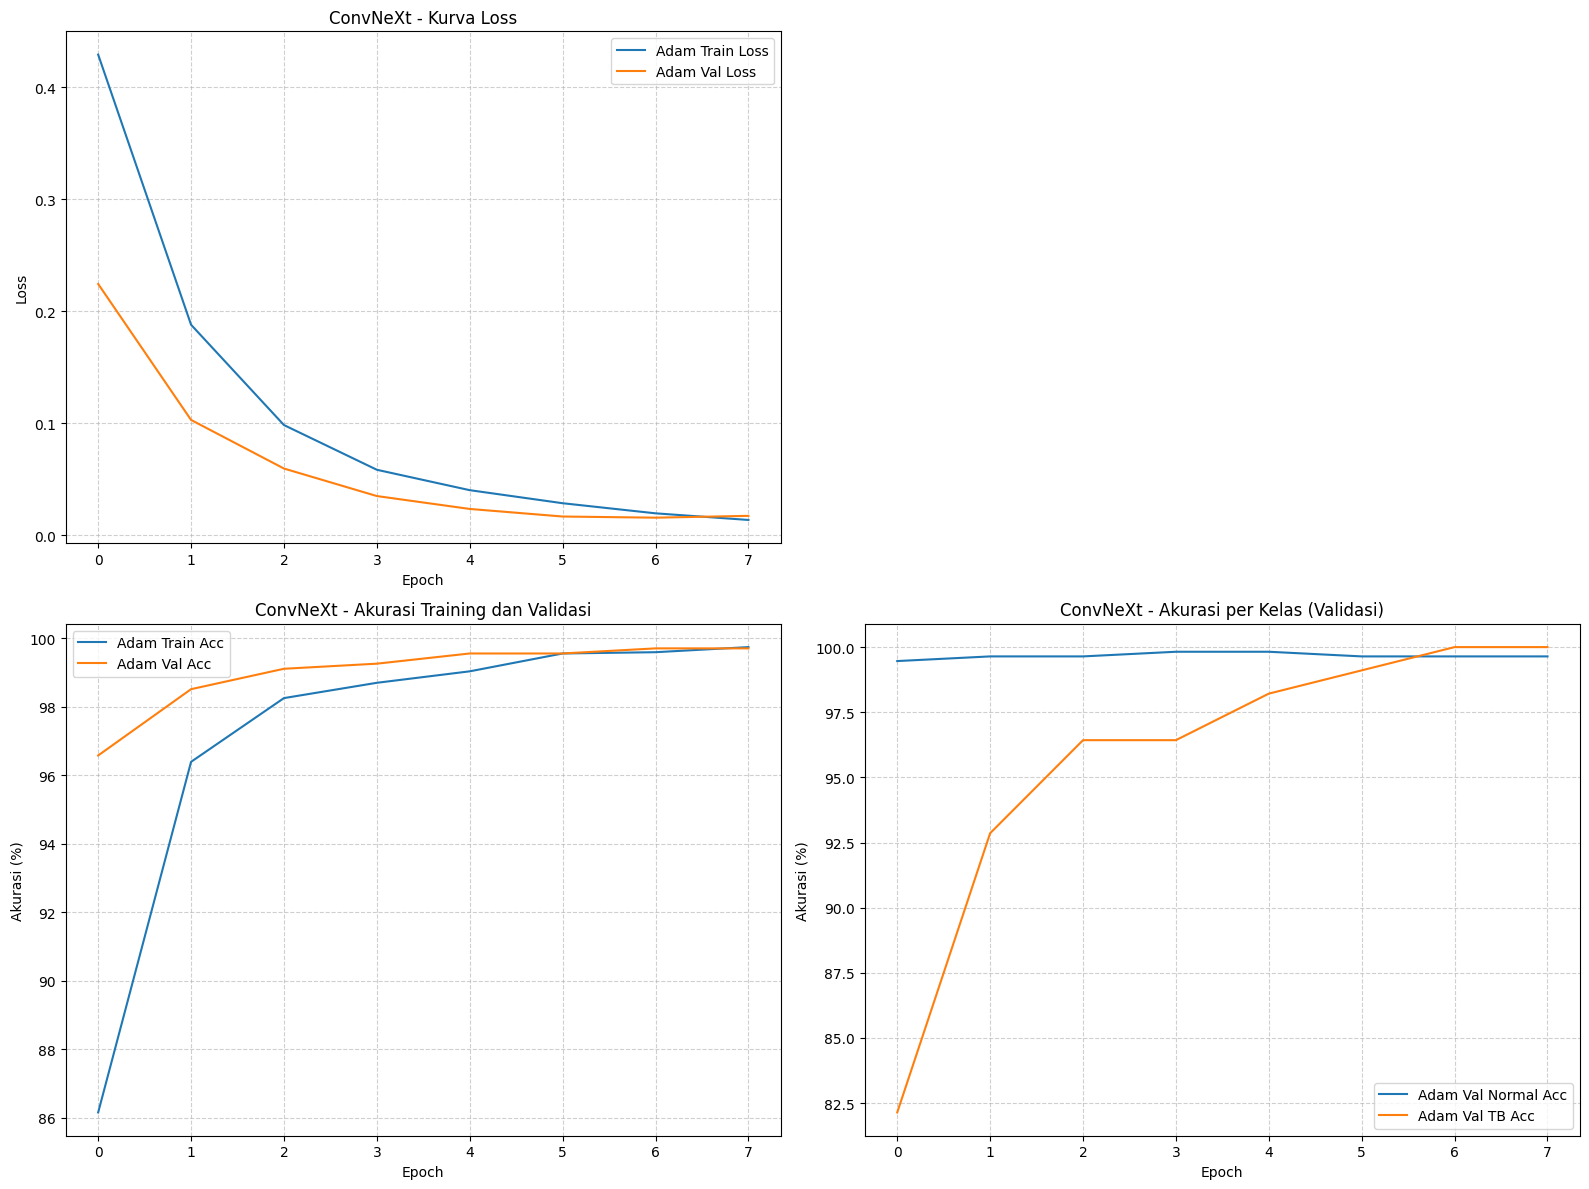

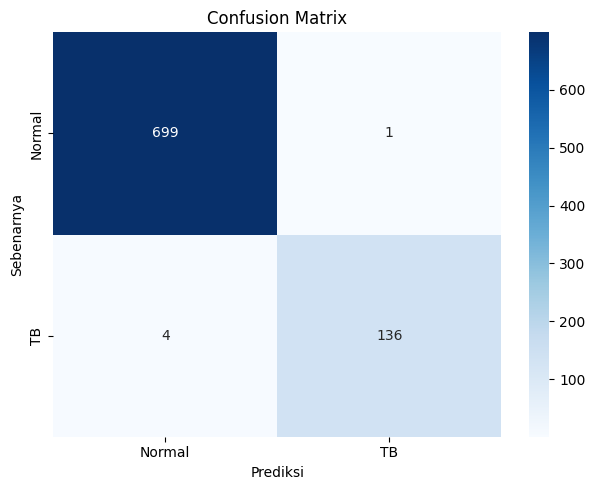


HASIL EVALUASI MODEL

Metrik Evaluasi pada Test Set (Adam):
Accuracy: 0.9940
Precision: 0.9927
Recall: 0.9714
F1-Score: 0.9819

Classification Report - ConvNeXt dengan Optimizer Adam
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00       700
          TB       0.99      0.97      0.98       140

    accuracy                           0.99       840
   macro avg       0.99      0.98      0.99       840
weighted avg       0.99      0.99      0.99       840



In [ ]:
# Membuat visualisasi kurva loss dan akurasi
plt.figure(figsize=(16, 12))

# Plot kurva loss
plt.subplot(2, 2, 1)
plt.plot(history_adam['train_loss'], label='Adam Train Loss')
plt.plot(history_adam['val_loss'], label='Adam Val Loss')
# plt.plot(history_adamw['train_loss'], label='AdamW Train Loss', linestyle='--')
# plt.plot(history_adamw['val_loss'], label='AdamW Val Loss', linestyle='--')
plt.title('ConvNeXt - Kurva Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)


# Plot kurva akurasi training dan validasi
plt.subplot(2, 2, 3)
plt.plot(history_adam['train_acc'], label='Adam Train Acc')
plt.plot(history_adam['val_acc'], label='Adam Val Acc')
# plt.plot(history_adamw['train_acc'], label='AdamW Train Acc', linestyle='--')
# plt.plot(history_adamw['val_acc'], label='AdamW Val Acc', linestyle='--')
plt.title('ConvNeXt - Akurasi Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot akurasi per kelas
plt.subplot(2, 2, 4)
plt.plot(history_adam['val_normal_acc'], label='Adam Val Normal Acc')
plt.plot(history_adam['val_tb_acc'], label='Adam Val TB Acc')
# plt.plot(history_adamw['val_normal_acc'], label='AdamW Val Normal Acc', linestyle='--')
# plt.plot(history_adamw['val_tb_acc'], label='AdamW Val TB Acc', linestyle='--')
plt.title('ConvNeXt - Akurasi per Kelas (Validasi)')
plt.xlabel('Epoch')
plt.ylabel('Akurasi (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('hasil_training.png')  # Simpan gambar jika diperlukan
plt.show()

# Visualisasi hasil evaluasi dengan confusion matrix
# Evaluasi akhir untuk model dengan Adam
_, _, _, _, all_preds_adam, all_labels_adam = evaluate(model_adam, test_loader, criterion, device)
metrics_adam = compute_metrics(all_preds_adam, all_labels_adam)

# Evaluasi akhir untuk model dengan AdamW
# _, _, _, _, all_preds_adamw, all_labels_adamw = evaluate(model_adamw, test_loader, criterion, device)
# metrics_adamw = compute_metrics(all_preds_adamw, all_labels_adamw)

# Buat confusion matrix untuk model Adam
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
labels = ['Normal', 'TB']
cm = metrics_adam['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Sebenarnya')

# Buat confusion matrix untuk model AdamW
# plt.subplot(1, 2, 2)
# cm = metrics_adamw['confusion_matrix']
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
# plt.title('Confusion Matrix - AdamW')
# plt.xlabel('Prediksi')
# plt.ylabel('Sebenarnya')

plt.tight_layout()
plt.savefig('confusion_matrix.png')  # Simpan gambar jika diperlukan
plt.show()

# Tampilkan ringkasan metrik evaluasi
print("\n" + "="*50)
print("HASIL EVALUASI MODEL")
print("="*50)

# Menampilkan metrik evaluasi untuk model Adam
print("\nMetrik Evaluasi pada Test Set (Adam):")
print(f"Accuracy: {metrics_adam['accuracy']:.4f}")
print(f"Precision: {metrics_adam['precision']:.4f}")
print(f"Recall: {metrics_adam['recall']:.4f}")
print(f"F1-Score: {metrics_adam['f1_score']:.4f}")

print("\n" + "="*50)
print("Classification Report - ConvNeXt dengan Optimizer Adam")
print("="*50)
print(classification_report(all_labels_adam, all_preds_adam, target_names=['Normal', 'TB']))

In [ ]:

model_path = '/content/convnext_adam_best_model.pth' # Sesuaikan path jika disimpan di lokasi lain
try:
    model_adam.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Model Adam berhasil dimuat dari {model_path}")
except FileNotFoundError:
    print(f"Error: Model Adam tidak ditemukan di {model_path}.")
    print("Pastikan file model ConvNeXt Adam terbaik ('convnext_adam_best_model.pth') sudah ada di lokasi yang benar.")
    exit() # Keluar jika model tidak ditemukan

# Set model ke mode evaluasi
model_adam.eval()

# Definisi transformasi untuk gambar testing
# Gunakan transformasi yang sama seperti saat evaluasi
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Fungsi untuk melakukan prediksi pada gambar tunggal
def predict_image(image_path, model, transform, device, classes=['Normal', 'Tuberculosis']):
    """
    Melakukan prediksi pada gambar tunggal menggunakan model yang sudah ditraining.
    """
    try:
        image = Image.open(image_path).convert('RGB')
    except FileNotFoundError:
        print(f"Error: File gambar tidak ditemukan di {image_path}")
        return None, None, None, None
    except Exception as e:
        print(f"Error saat memuat gambar {image_path}: {e}")
        return None, None, None, None

    # Terapkan transformasi
    image_tensor = transform(image).unsqueeze(0).to(device) # Tambahkan batch dimension

    # Lakukan prediksi
    with torch.no_grad():
        outputs = model(image_tensor)
        # Gunakan softmax untuk mendapatkan probabilitas
        probabilities = torch.softmax(outputs, dim=1)
        # Ambil prediksi kelas dengan probabilitas tertinggi
        confidence, predicted_class_idx = torch.max(probabilities, 1)

    predicted_label = classes[predicted_class_idx.item()]
    confidence_score = confidence.item()

    # Hitung probabilitas untuk kedua kelas
    prob_normal = probabilities[0, 0].item()
    prob_tb = probabilities[0, 1].item()


    return predicted_label, confidence_score, prob_normal, prob_tb

# Path ke folder yang berisi gambar untuk diuji
# Ganti dengan path folder Anda
test_folder_path = '/content/testing_image' # CONTOH: ganti dengan folder di Google Drive atau lokasi lain

# Pastikan folder test ada
if not os.path.exists(test_folder_path):
    print(f"Error: Folder test tidak ditemukan di {test_folder_path}")
    print("Buat folder ini atau ganti path ke folder gambar Anda.")
else:
    # Dapatkan daftar semua file gambar di folder test
    image_files = [f for f in os.listdir(test_folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print(f"Tidak ada file gambar (.png, .jpg, .jpeg) ditemukan di folder {test_folder_path}")
    else:
        print(f"\nMelakukan prediksi pada {len(image_files)} gambar dari folder: {test_folder_path}")
        print("-" * 50)

        results = []
        # Proses setiap gambar di folder
        for image_file in tqdm(image_files, desc="Memproses Gambar"):
            image_path = os.path.join(test_folder_path, image_file)

            predicted_label, confidence_score, prob_normal, prob_tb = predict_image(
                image_path, model_adam, test_transform, device
            )

            if predicted_label is not None: # Jika gambar berhasil dimuat dan diproses
                 results.append({
                    'filename': image_file,
                    'predicted_label': predicted_label,
                    'confidence': confidence_score,
                    'probability_normal': prob_normal,
                    'probability_tb': prob_tb
                })
                 print(f"File: {image_file}")
                 print(f"  Prediksi: {predicted_label} (Confidence: {confidence_score:.4f})")
                 print(f"  Probabilitas Normal: {prob_normal:.4f}, Probabilitas TB: {prob_tb:.4f}")
                 print("-" * 20)

        # Tampilkan ringkasan hasil
        print("\n" + "="*50)
        print("RINGKASAN HASIL PREDIKSI FOLDER")
        print("="*50)

        if results:
            # Hitung jumlah prediksi per kelas
            predicted_normal_count = sum(1 for r in results if r['predicted_label'] == 'Normal')
            predicted_tb_count = sum(1 for r in results if r['predicted_label'] == 'Tuberculosis')

            print(f"Total gambar diproses: {len(results)}")
            print(f"Diprediksi Normal: {predicted_normal_count}")
            print(f"Diprediksi TB: {predicted_tb_count}")

            # Tampilkan detail hasil (opsional)
            print("\nDetail Hasil:")
            for res in results:
            print(f"  {res['filename']}: Prediksi={res['predicted_label']}, Confidence={res['confidence']:.4f}")

        else:
            print("Tidak ada gambar yang berhasil diproses.")



Model Adam berhasil dimuat dari /content/convnext_adam_best_model.pth

Melakukan prediksi pada 2 gambar dari folder: /content/testing_image
--------------------------------------------------


Memproses Gambar: 100%|██████████| 2/2 [00:00<00:00, 51.26it/s]

File: normal.jpg
  Prediksi: Normal (Confidence: 0.9007)
  Probabilitas Normal: 0.9007, Probabilitas TB: 0.0993
--------------------
File: tuberculosis2.png
  Prediksi: Tuberculosis (Confidence: 0.9937)
  Probabilitas Normal: 0.0063, Probabilitas TB: 0.9937
--------------------

RINGKASAN HASIL PREDIKSI FOLDER
Total gambar diproses: 2
Diprediksi Normal: 1
Diprediksi TB: 1
